In [1]:
## Relevant modules.
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 

We are going to work with a subpanel (subset) of our original panel data. That subpanel includes observations (doctors) of 4 specialties, 2 departments and 5 years. That group was chosen because it guarantees that each specialty in each department in each year has more than 30 observations (doctors). The subpanel has 2552 entries instead of the original 8294 entries in the original panel. In addition, simple dummies for each specialty and department are created. Interaction dummies between n_visits and those simple dummies are also created.

In [2]:
## Reading file.
file = 'data/data_panel.csv'
panel = pd.read_csv(file, header=0)

## Group with 4 specialties, 2 departments and 5 years.
## This group has more than 30 observations (doctors)...
## ...for each specialty in each department in each year.

group_1 = panel.groupby(['spec_code','dep_code','year'])[['doc_code']].count()
group_1.rename(columns={'doc_code': 'doc_count'}, inplace=True)
group_1 = group_1[group_1['doc_count'] > 30].reset_index()

group_2 = group_1.groupby(['spec_code','dep_code'])[['year']].count()
group_2.rename(columns={'year': 'year_count'}, inplace=True)
group_2 = group_2[group_2['year_count'] == 5].reset_index()

group_3 = group_2.groupby(['spec_code'])[['dep_code']].count()
group_3.rename(columns={'dep_code': 'dep_count'}, inplace=True)
group_3 = group_3[group_3['dep_count'] > 1].reset_index()

merge_3_2 = pd.merge(group_3, group_2, on=['spec_code'])
merge_3_2_1 = pd.merge(merge_3_2, group_1, on=['spec_code','dep_code'])
group = merge_3_2_1.drop(['year_count','dep_count'], axis=1)

## Subpanel from original panel taking into account only the above group.
## There are 2552 entries instead of 8294 entries. 
## Variable surgeries2visits and dummies for each specialty and department are created.
## Interaction variables between n_visits and dummies are created

subpanel = pd.merge(panel, group, on=['spec_code','dep_code','year'])
subpanel.drop('doc_count', axis=1, inplace=True)
subpanel['surgeries2visits']=subpanel['n_surgeries']/subpanel['n_visits']

dummies = pd.get_dummies(subpanel[['spec_en','department']])
dummies_old_names = list(dummies.columns.values)
dummies_new_names = []

for i in dummies_old_names:
    if i[0:4] == 'spec':
        dummies_new_names.append(i[0:4]+i[7:11])
    elif i[0:4] == 'depa':
        dummies_new_names.append(i[0:3]+i[10:14])

dummies_dic_names = dict(zip(dummies_old_names, dummies_new_names))
dummies.rename(columns=dummies_dic_names,inplace=True)

subpanel = pd.concat([subpanel,dummies],axis=1)
for i in dummies_new_names:
    subpanel['vis_'+i]=subpanel['n_visits']*subpanel[i]
print(subpanel.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2552 entries, 0 to 2551
Data columns (total 25 columns):
doc_code            2552 non-null int64
spec_code           2552 non-null int64
spec_es             2552 non-null object
spec_en             2552 non-null object
year                2552 non-null int64
n_visits            2552 non-null int64
n_surgeries         2552 non-null int64
n_patients          2552 non-null int64
c_visit             2552 non-null float64
c_surgery           2552 non-null float64
dep_code            2552 non-null int64
department          2552 non-null object
surgeries2visits    2552 non-null float64
spec_der            2552 non-null uint8
spec_gyn            2552 non-null uint8
spec_oph            2552 non-null uint8
spec_oto            2552 non-null uint8
dep_ant             2552 non-null uint8
dep_val             2552 non-null uint8
vis_spec_der        2552 non-null int64
vis_spec_gyn        2552 non-null int64
vis_spec_oph        2552 non-null int64
vis_

Using supervised classification to predict excessive number of surgeries.  
First, we need to define what excessive number of surgeries should be.  
We need to pay attention to the fact that number of surgeries is not normally distributed.

count    2552.000000
mean       20.603840
std        36.551873
min         1.000000
25%         2.750000
50%         7.000000
75%        21.000000
max       447.000000
Name: n_surgeries, dtype: float64


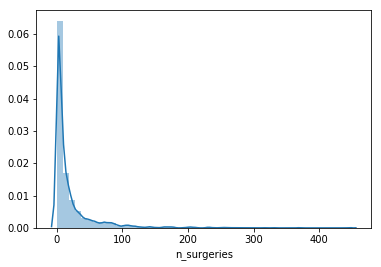

In [3]:
print(subpanel['n_surgeries'].describe())
fig = sns.distplot(subpanel['n_surgeries'])

Because number of surgeries is not normally distributed, instead of using mean and std, we are going to use a certain percentile to define the threshold of what constitutes excessive number of surgeries. We are going to use the 70th percentile, but that percentile can be changed in the very beginning of the code below.

In [4]:
v_percentile = 70
surgeries_threshold = np.percentile(subpanel['n_surgeries'], v_percentile)
subpanel['ex_surgeries'] = [1 if i >= surgeries_threshold
                            else 0 for i in subpanel['n_surgeries']]

print('New variable: ex_surgeries (excessive surgeries).')
print('Criterion for ex_surgeries = 1:')
print('n_surgeries >= than the',v_percentile,'percentile.\n')
print(subpanel['ex_surgeries'].describe())

New variable: ex_surgeries (excessive surgeries).
Criterion for ex_surgeries = 1:
n_surgeries >= than the 70 percentile.

count    2552.000000
mean        0.306426
std         0.461099
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: ex_surgeries, dtype: float64


Now we are going to perform and compare different types of supervised classification.

In [5]:
## Getting the necessary modules (tools).
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
                                  RobustScaler, Normalizer,\
                                  QuantileTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,\
                                    GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet,\
                                 LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,\
                            roc_auc_score, mean_squared_error
from scipy.stats import norm, t, probplot
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [6]:
## Defining attributes X and target y.
X_list = ['n_visits','year',
          'spec_gyn','vis_spec_gyn',
          'spec_oph','vis_spec_oph',
          'spec_oto','vis_spec_oto',
          'dep_ant','vis_dep_ant']
X = subpanel[X_list].astype(float)
y = subpanel['ex_surgeries'].astype(float)

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [7]:
## Using k-NN: k-nearest neighbors.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
n_neighbors_space = np.linspace(1, 20, 20).astype(int)
parameters = {'knn__n_neighbors':n_neighbors_space}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using k-NN: k-nearest neighbors.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using k-NN: k-nearest neighbors.
Accuracy: 0.8934169278996865
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       449
         1.0       0.86      0.77      0.81       189

   micro avg       0.89      0.89      0.89       638
   macro avg       0.88      0.86      0.87       638
weighted avg       0.89      0.89      0.89       638

Tuned Model Parameters: {'knn__n_neighbors': 7}


In [8]:
## Using logistic regression.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(solver='lbfgs'))]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
c_space = np.linspace(0.01, 20, 100)
parameters = {'logreg__C':c_space}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using logistic regression.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using logistic regression.
Accuracy: 0.8793103448275862
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92       449
         1.0       0.84      0.74      0.78       189

   micro avg       0.88      0.88      0.88       638
   macro avg       0.87      0.84      0.85       638
weighted avg       0.88      0.88      0.88       638

Tuned Model Parameters: {'logreg__C': 0.41383838383838384}


In [9]:
## Using decision tree.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('tree', DecisionTreeClassifier())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
parameters = {'tree__max_depth': [0.1, 0.5, 1, 2, 3, 4, 5, None],
              'tree__max_features': [0.1, 0.5, 1, 2, 'auto', 'sqrt', 'log2', None],
              'tree__min_samples_leaf': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
              'tree__criterion': ["gini", "entropy"]}

## Instantiate the GridSearchCV object: cv.
cv = RandomizedSearchCV(pipeline, param_distributions=parameters, cv=5)
#cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using decision tree with RandomizedSearchCV().')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using decision tree with RandomizedSearchCV().
Accuracy: 0.8056426332288401
              precision    recall  f1-score   support

         0.0       0.90      0.82      0.86       449
         1.0       0.64      0.78      0.70       189

   micro avg       0.81      0.81      0.81       638
   macro avg       0.77      0.80      0.78       638
weighted avg       0.82      0.81      0.81       638

Tuned Model Parameters: {'tree__min_samples_leaf': 0.01, 'tree__max_features': None, 'tree__max_depth': 1, 'tree__criterion': 'gini'}


In [10]:
## Using SVM: Support Vector Machine.

## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using SVM: Support Vector Machine.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using SVM: Support Vector Machine.
Accuracy: 0.8871473354231975
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92       449
         1.0       0.86      0.74      0.79       189

   micro avg       0.89      0.89      0.89       638
   macro avg       0.88      0.84      0.86       638
weighted avg       0.89      0.89      0.88       638

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.01}


Conclusion: k-NN with 7 neighbors seems to be the best classifier based on accuracy, precision (for 1.0) and recall (for 1.0).  
Let's see some more details regarding that k-NN classifier.

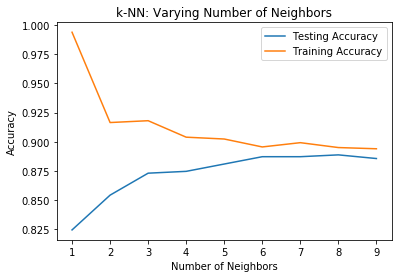

In [11]:
## Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
## Loop over different values of k
for i, k in enumerate(neighbors):
    ## Setup a k-NN Classifier with k neighbors: knn
    knn_plot = KNeighborsClassifier(n_neighbors=k)
    ## Fit the classifier to the training data
    knn_plot.fit(X_train, y_train)
    ## Compute accuracy on the training set
    train_accuracy[i] = knn_plot.score(X_train, y_train)
    ## Compute accuracy on the testing set
    test_accuracy[i] = knn_plot.score(X_test, y_test)
## Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

In [12]:
## Repeating k-NN: k-nearest neighbors.
## Setup the pipeline.
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
n_neighbors_space = np.linspace(1, 20, 20).astype(int)
parameters = {'knn__n_neighbors':n_neighbors_space}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using k-NN: k-nearest neighbors.')
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Using k-NN: k-nearest neighbors.
Accuracy: 0.8934169278996865

Confusion matrix:
[[425  24]
 [ 44 145]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93       449
         1.0       0.86      0.77      0.81       189

   micro avg       0.89      0.89      0.89       638
   macro avg       0.88      0.86      0.87       638
weighted avg       0.89      0.89      0.89       638

Tuned Model Parameters: {'knn__n_neighbors': 7}


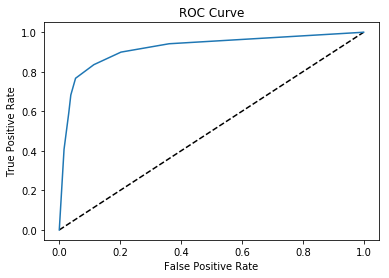

AUC: 0.9182133135362534


In [13]:
## Compute predicted probabilities: y_pred_prob
y_pred_prob = cv.predict_proba(X_test)[:,1]
## Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
## Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
## Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

k-NN with 7 neighbors is a good supervised classifier to identify excessive number of surgeries.  
Now, can we predict the number of surgeries in general?  
We will try to answer that question with  elastic net and linear regression.

First, we will do a quick test using full data to show that coeficients and p-values from sklearn match those from statsmodels.  
We will also take the opportunity to analyze residuals and look for outliers.

Linear regression using sklearn:
       Variables  Coefficients  Standard Errors  t values  Probabilites
0      Intercept    -2026.9084          644.359    -3.146         0.002
1       n_visits        0.1303            0.006    21.842         0.000
2           year        1.0138            0.321     3.162         0.002
3       spec_gyn       -9.0210            1.852    -4.871         0.000
4   vis_spec_gyn       -0.1037            0.005   -19.085         0.000
5       spec_oph      -10.7700            1.785    -6.033         0.000
6   vis_spec_oph       -0.0546            0.005   -10.735         0.000
7       spec_oto      -14.9773            1.932    -7.754         0.000
8   vis_spec_oto        0.0086            0.006     1.454         0.146
9        dep_ant        0.6471            1.313     0.493         0.622
10   vis_dep_ant       -0.0013            0.006    -0.228         0.819 

Linear regression using statsmodels:
                            OLS Regression Results              

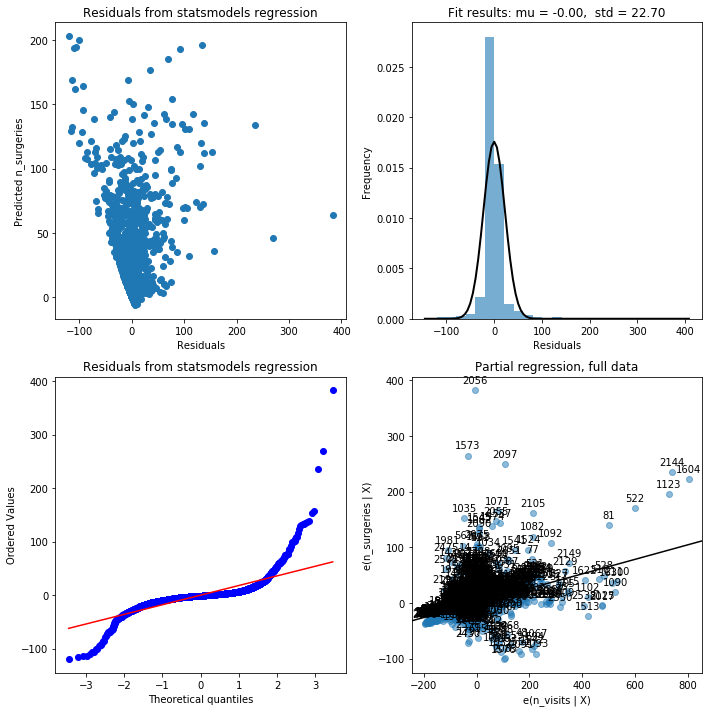

In [14]:
## Defining attributes X and target y.
X_list = ['n_visits','year',
          'spec_gyn','vis_spec_gyn',
          'spec_oph','vis_spec_oph',
          'spec_oto','vis_spec_oto',
          'dep_ant','vis_dep_ant']
X = subpanel[X_list].astype(float)
y = subpanel['n_surgeries'].astype(float)

## Using sklearn.
lm = LinearRegression()
lm.fit(X,y)
params = np.append(lm.intercept_,lm.coef_)
predictions = lm.predict(X)

#newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
#MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
## Note if you don't want to use a DataFrame replace the two lines above with
newX = np.append(np.ones((len(X),1)), X, axis=1)
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/sd_b
p_values =[2*(1-t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)
variables = ['Intercept']+X_list

myDF3 = pd.DataFrame()
myDF3["Variables"],myDF3["Coefficients"],myDF3["Standard Errors"],\
myDF3["t values"],myDF3["Probabilites"] = [variables,params,sd_b,ts_b,p_values]
print('Linear regression using sklearn:')
print(myDF3,'\n')

## Using statsmodels.
m = ols('n_surgeries ~ n_visits+year+\
         spec_gyn+vis_spec_gyn+\
         spec_oph+vis_spec_oph+\
         spec_oto+vis_spec_oto+\
         dep_ant+vis_dep_ant',subpanel).fit()
print('Linear regression using statsmodels:') 
print(m.summary())

## Analyzing residuals from statsmodels regression.
residuals = subpanel['n_surgeries'] - m.fittedvalues

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0][0].scatter(residuals, m.fittedvalues)
ax[0][0].set_title('Residuals from statsmodels regression')
ax[0][0].set_xlabel("Residuals")
ax[0][0].set_ylabel("Predicted n_surgeries")

mu, std = norm.fit(residuals)
ax[0][1].hist(residuals, bins=25, density=True, alpha=0.6)
xmin, xmax = ax[0][1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][1].plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
ax[0][1].set_title(title)
ax[0][1].set_xlabel("Residuals")
ax[0][1].set_ylabel("Frequency")

probplot(residuals, dist=norm, fit=True, plot=ax[1][0])
ax[1][0].set_title('Residuals from statsmodels regression')

sm.graphics.plot_partregress(endog='n_surgeries', exog_i='n_visits',
                             exog_others=['spec_gyn','vis_spec_gyn',
                                          'spec_oph','vis_spec_oph',
                                          'spec_oto','vis_spec_oto',
                                          'dep_ant','vis_dep_ant',
                                          'year'], data=subpanel,
                             obs_labels=True, label_kwargs={'fontsize':10},
                             alpha=0.5, ax=ax[1][1])
ax[1][1].set_title('Partial regression, full data')

fig.tight_layout()
plt.show()

There are definetly problems with outliers. Let's try to identify and remove them.  
Observation: a more careful analysis should study each outlier before deciding to remove or not it, but we are taking a shortcut since some outliers are pretty obvious.

List of outlier indexes:
[14, 42, 48, 522, 560, 564, 567, 591, 594, 1032, 1034, 1035, 1062, 1063, 1067, 1071, 1081, 1082, 1123, 1430, 1537, 1542, 1545, 1551, 1559, 1563, 1573, 1574, 1576, 1604, 1981, 2055, 2056, 2075, 2083, 2090, 2091, 2093, 2097, 2105, 2144, 2475] 

Linear regression using statsmodels without outliers:
                            OLS Regression Results                            
Dep. Variable:            n_surgeries   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     681.9
Date:                Sat, 02 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:06:14   Log-Likelihood:                -10301.
No. Observations:                2510   AIC:                         2.062e+04
Df Residuals:                    2499   BIC:                         2.069e+04
Df Model:                          10         

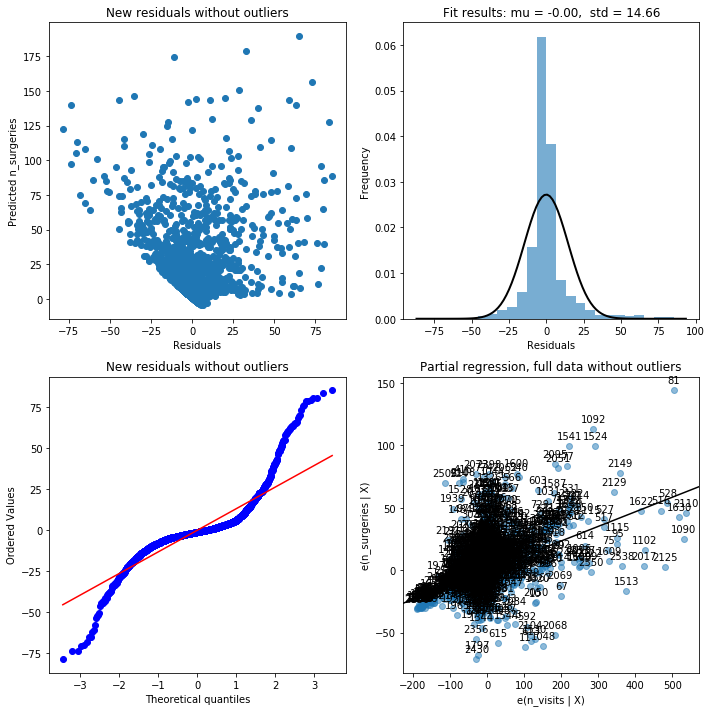

In [15]:
## Identifying outliers.
test = m.outlier_test()
outliers = ((i,t) for i,t in enumerate(test.iloc[:,2]) if t < 0.5)
outliers_indexes = []
for j in outliers:
    outliers_indexes.append(j[0])
print('List of outlier indexes:')
print(outliers_indexes,'\n')

## Linear regression and residual analysis without outliers.
new_subpanel = subpanel.drop(outliers_indexes, axis=0)
new_m = ols('n_surgeries ~ n_visits+year+\
         spec_gyn+vis_spec_gyn+\
         spec_oph+vis_spec_oph+\
         spec_oto+vis_spec_oto+\
         dep_ant+vis_dep_ant',new_subpanel).fit()
print('Linear regression using statsmodels without outliers:')
print(new_m.summary(),'\n')

new_residuals = new_subpanel['n_surgeries'] - new_m.fittedvalues

fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0][0].scatter(new_residuals, new_m.fittedvalues)
ax[0][0].set_title('New residuals without outliers')
ax[0][0].set_xlabel("Residuals")
ax[0][0].set_ylabel("Predicted n_surgeries")

mu, std = norm.fit(new_residuals)
ax[0][1].hist(new_residuals, bins=25, density=True, alpha=0.6)
xmin, xmax = ax[0][1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][1].plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
ax[0][1].set_title(title)
ax[0][1].set_xlabel("Residuals")
ax[0][1].set_ylabel("Frequency")

probplot(new_residuals, dist=norm, fit=True, plot=ax[1][0])
ax[1][0].set_title('New residuals without outliers')

sm.graphics.plot_partregress(endog='n_surgeries', exog_i='n_visits',
                             exog_others=['spec_gyn','vis_spec_gyn',
                                          'spec_oph','vis_spec_oph',
                                          'spec_oto','vis_spec_oto',
                                          'dep_ant','vis_dep_ant',
                                          'year'], data=new_subpanel,
                             obs_labels=True, label_kwargs={'fontsize':10},
                             alpha=0.5, ax=ax[1][1])
ax[1][1].set_title('Partial regression, full data without outliers')

fig.tight_layout()
plt.show()

Residuals still are not perfect but they are much better without the outliers.  
So far, we have been using full data to predict the number of surgeries in general. Now that we have identified and removed outliers, let's use train and test sets again. We are first going to perform analyses using elastic net and then linear regression. In order to keep the interpretation of the coeficients easy (for n_visits in particular), we are not going to center/scale the feature set.

In [16]:
## Elastic net: defining attributes X and target y.
X_list = ['n_visits','year',
          'spec_gyn','vis_spec_gyn',
          'spec_oph','vis_spec_oph',
          'spec_oto','vis_spec_oto',
          'dep_ant','vis_dep_ant']
X = new_subpanel[X_list].astype(float)
y = new_subpanel['n_surgeries'].astype(float)

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Setup the pipeline.
steps = [#('scaler', StandardScaler()),
         ('elastic_net', ElasticNet(max_iter=10000, tol=0.01))]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
alpha_space = [0.5, 1, 1.5]
l1_space = np.linspace(0, 1, 20)
parameters = {'elastic_net__alpha': alpha_space,
              'elastic_net__l1_ratio': l1_space}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using elastic net without centering/scaling.')
print("Tuned Model Parameters: {}".format(cv.best_params_))
print('R^2 (Accuracy): {}'.format(cv.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: {}'.format(rmse))
intercept = cv.best_estimator_.named_steps['elastic_net'].intercept_
coeficients = cv.best_estimator_.named_steps['elastic_net'].coef_

params = np.append(intercept,coeficients)
predictions = y_pred
newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
p_values =[2*(1-t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)
variables = ['Intercept']+X_list

myDF3 = pd.DataFrame()
myDF3["Variables"],myDF3["Coefficients"],myDF3["Standard Errors"],\
myDF3["t values"],myDF3["Probabilites"] = [variables,params,sd_b,ts_b,p_values]
print(myDF3)

C:\Users\Terry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Terry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Terry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Terry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Using elastic net without centering/scaling.
Tuned Model Parameters: {'elastic_net__alpha': 0.5, 'elastic_net__l1_ratio': 0.0}
R^2 (Accuracy): 0.7380718637644101
Root Mean Squared Error: 15.188794318875578
       Variables  Coefficients  Standard Errors  t values  Probabilites
0      Intercept     -919.7709          882.373    -1.042         0.298
1       n_visits        0.1371            0.009    15.278         0.000
2           year        0.4588            0.439     1.045         0.296
3       spec_gyn        0.0916            2.688     0.034         0.973
4   vis_spec_gyn       -0.1236            0.008   -14.856         0.000
5       spec_oph       -0.1881            2.549    -0.074         0.941
6   vis_spec_oph       -0.0810            0.007   -11.255         0.000
7       spec_oto       -0.7663            2.692    -0.285         0.776
8   vis_spec_oto       -0.0376            0.009    -4.395         0.000
9        dep_ant       -0.5300            1.882    -0.282         0.778
10

C:\Users\Terry\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


I don't understand why I am getting warnings about convergence. I have tried to adjust max_iter and tol in ElasticNet() but I am still getting the warnings. Moreover, according to documentation, "l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha" and "alpha = 0 is equivalent to an ordinary least square, solved by the LinearRegression object [...] using alpha = 0 with the Lasso object is not advised". Let's then try simple linear regression.

In [17]:
## Linear regression: defining attributes X and target y.
X_list = ['n_visits','year',
          'spec_gyn','vis_spec_gyn',
          'spec_oph','vis_spec_oph',
          'spec_oto','vis_spec_oto',
          'dep_ant','vis_dep_ant']
X = new_subpanel[X_list].astype(float)
y = new_subpanel['n_surgeries'].astype(float)

## Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Setup the pipeline.
steps = [#('scaler', StandardScaler()),
         ('linreg', LinearRegression())]
pipeline = Pipeline(steps)

## Specify the hyperparameter space.
parameters = {'linreg__fit_intercept':[True, False]}

## Instantiate the GridSearchCV object: cv.
cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

## Fit to the training set.
cv.fit(X_train, y_train)

## Predict the labels of the test set: y_pred.
y_pred = cv.predict(X_test)

## Compute and print metrics.
print('Using linear regression without centering/scaling.')
print("Tuned Model Parameters: {}".format(cv.best_params_))
print('R^2 (Accuracy): {}'.format(cv.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: {}'.format(rmse))
intercept = cv.best_estimator_.named_steps['linreg'].intercept_
coeficients = cv.best_estimator_.named_steps['linreg'].coef_
#Intercept = cv.best_estimator_.steps[1][1].intercept_.round(4)
#Coeficients = cv.best_estimator_.steps[1][1].coef_.round(4)

params = np.append(intercept,coeficients)
predictions = y_pred
newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
MSE = (sum((y_test-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
p_values =[2*(1-t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)
variables = ['Intercept']+X_list

myDF3 = pd.DataFrame()
myDF3["Variables"],myDF3["Coefficients"],myDF3["Standard Errors"],\
myDF3["t values"],myDF3["Probabilites"] = [variables,params,sd_b,ts_b,p_values]
print(myDF3)

Using linear regression without centering/scaling.
Tuned Model Parameters: {'linreg__fit_intercept': True}
R^2 (Accuracy): 0.7464380659059715
Root Mean Squared Error: 14.944254419536774
       Variables  Coefficients  Standard Errors  t values  Probabilites
0      Intercept    -1173.5458          868.167    -1.352         0.177
1       n_visits        0.1198            0.009    13.576         0.000
2           year        0.5883            0.432     1.362         0.174
3       spec_gyn       -4.4246            2.645    -1.673         0.095
4   vis_spec_gyn       -0.1146            0.008   -14.001         0.000
5       spec_oph       -5.4608            2.508    -2.178         0.030
6   vis_spec_oph       -0.0700            0.007    -9.891         0.000
7       spec_oto       -9.0436            2.649    -3.414         0.001
8   vis_spec_oto       -0.0186            0.008    -2.206         0.028
9        dep_ant       -2.8613            1.852    -1.545         0.123
10   vis_dep_ant      

Because dummies for specialty dermatology and department valle del cauca were left out of the regression to avoid perfect collinearity with the other dummies, the estimated coeficientes for intercept and n_visits assume that specialty is dermatology and department is valle del cauca. The estimated coeficients for the dummies, including the interaction dummies, when activated (when a dummy is 1), will modify the coeficients for intercept and n_visits in order to represent the activated specialty and/or department. That being said:
- Intercept is not significant: it may be zero. 
- n_visits is significant: one more visit increase n_surgeries in 0.12 if dermatology and valle del cauca.
- year is not significant.
- Compared to dermatology, gynecology/obstretics has less 4.4246 units of intercept (but same intercept is also possible) and less 0.1146 units of coeficient for n_visits.
- Compared to dermatology, ophthalmology has less 5.4608 units of intercept and less 0.0700 units of coeficient for n_visits.
- Compared to dermatology, otorhinolaryngology has less 9.0436 units of intercept and less 0.0186 units of coeficient for n_visits (almost the same).
- Compared to valle del cauca, antioquia has less 2.8613 units of intercept (but same intercept is also possible) and more 0.0217 units of coeficient for n_visits.
- These results are compatible with what we saw in file '06_correlations'.  

Let's now see the residuals.

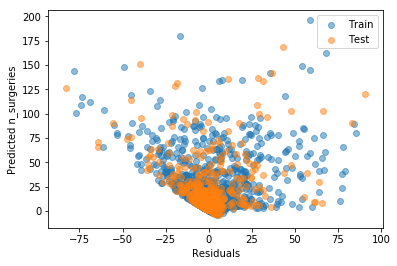

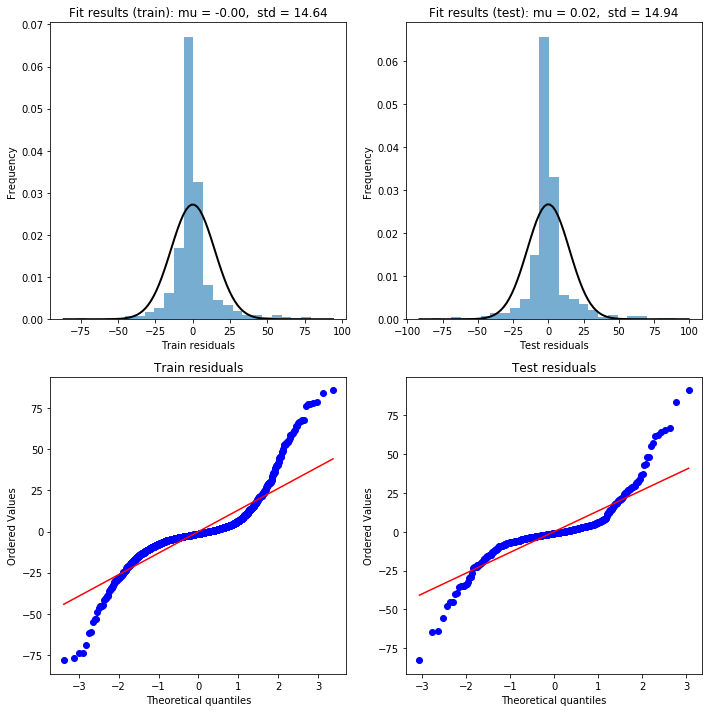

In [18]:
residuals_train = y_train - cv.predict(X_train)
residuals_test = y_test - cv.predict(X_test)

plt.scatter(residuals_train, cv.predict(X_train), alpha=0.5, label='Train')
plt.scatter(residuals_test, cv.predict(X_test), alpha=0.5, label='Test')
plt.xlabel("Residuals")
plt.ylabel("Predicted n_surgeries")
plt.legend()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10,10))

mu, std = norm.fit(residuals_train)
ax[0][0].hist(residuals_train, bins=25, density=True, alpha=0.6)
xmin, xmax = ax[0][0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][0].plot(x, p, 'k', linewidth=2)
title = "Fit results (train): mu = %.2f,  std = %.2f" % (mu, std)
ax[0][0].set_title(title)
ax[0][0].set_xlabel("Train residuals")
ax[0][0].set_ylabel("Frequency")

mu, std = norm.fit(residuals_test)
ax[0][1].hist(residuals_test, bins=25, density=True, alpha=0.6)
xmin, xmax = ax[0][1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax[0][1].plot(x, p, 'k', linewidth=2)
title = "Fit results (test): mu = %.2f,  std = %.2f" % (mu, std)
ax[0][1].set_title(title)
ax[0][1].set_xlabel("Test residuals")
ax[0][1].set_ylabel("Frequency")

probplot(residuals_train, dist=norm, fit=True, plot=ax[1][0])
ax[1][0].set_title('Train residuals')

probplot(residuals_test, dist=norm, fit=True, plot=ax[1][1])
ax[1][1].set_title('Test residuals')

fig.tight_layout()
plt.show()

Again, as seen before, residuals are not perfect but not that bad. One good thing is that residuals behave similarly if train or test. One problem is that the variance of the residuals tends to increase as the predicted n_surgeries increases, meaning that incertainty of our model increases for high values of predicted n_surgeries. Suggestions to fix it?

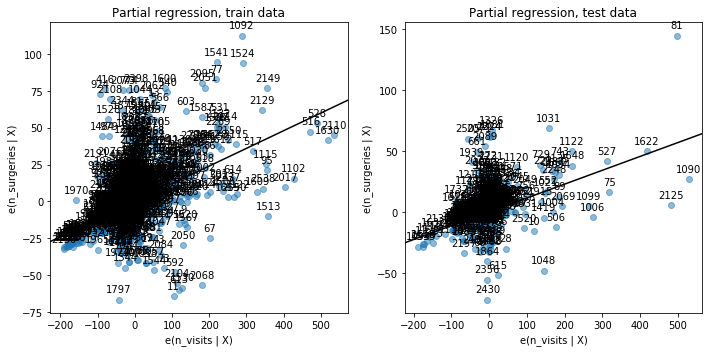

In [19]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)
df_test = pd.merge(y_test, X_test, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

sm.graphics.plot_partregress(endog='n_surgeries', exog_i='n_visits',
                             exog_others=['spec_gyn','vis_spec_gyn',
                                          'spec_oph','vis_spec_oph',
                                          'spec_oto','vis_spec_oto',
                                          'dep_ant','vis_dep_ant',
                                          'year'], data=df_train,
                             obs_labels=True, label_kwargs={'fontsize':10},
                             alpha=0.5, ax=ax[0])
ax[0].set_title('Partial regression, train data')

sm.graphics.plot_partregress(endog='n_surgeries', exog_i='n_visits',
                             exog_others=['spec_gyn','vis_spec_gyn',
                                          'spec_oph','vis_spec_oph',
                                          'spec_oto','vis_spec_oto',
                                          'dep_ant','vis_dep_ant',
                                          'year'], data=df_test,
                             obs_labels=True, label_kwargs={'fontsize':10},
                             alpha=0.5, ax=ax[1])
ax[1].set_title('Partial regression, test data')

fig.tight_layout()
plt.show()

Again, model behaves similarly if train or test. It seems that we can explain a lot the number of surgeries based on number of visits, doctor's specialty and department (year doesn't seem to be significant, at least in the short-run of one year to the next year). The space for moral hazard and induced demand to influence number of surgeries seems to be small.